# Détection d'anomalie :  Approche encodeur
Ce Notebook à pour but de présenter la construction d'un autoencodeur permettant de détecter les signalements d'un nouveau type. Pour ce faire nous utilisons l'exemple des prothèses PIP comme jeu de données de validation. La méthode est la suivante : 
- Nous excluons les declarations concernants les PIP et créant ainsi deux dataset : PIP et NO_PIP
- Avec le dataset PIP nous créons un jeu de test (0.2) et de train qui nous permet d'entrainer notre autoencodeur
- Nous construisons et entrainons un autoencodeur avec la Loss MSE (Mean Squared Error) et le TFIDF du texte en entrée
- Nous définition un seuil d'anomalie en calculant la MSE sur le jeu de test PIP
- Nous calculons le mse pour les données des prothèse PIP et assignons la valeure 1 à celle qui sont au dessus du seuil
- Nous calculons le taux de détetion d'anomalie : Nombre d'anomalie détecté par l'auto-encoder/nombre de signalements PIP

In [298]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn


from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, RepeatVector, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import roc_auc_score, average_precision_score


## Chargement des données et gestion rapide des NaN

In [68]:
mrv = pd.read_csv("../data/data_mrv/declaration_mrv_complet.csv")

In [72]:
df = mrv[['DESCRIPTION_INCIDENT','TYPE_VIGILANCE','LIBELLE_COMMERCIAL','DCO',
                         'REFERENCE_COMMERCIALE','ETAT_PATIENT','FABRICANT','DCO_ID','CLASSIFICATION']]
# On complète les NaN avec du vide
df['ETAT_PATIENT'] = df['ETAT_PATIENT'].fillna("")
df['DESCRIPTION_INCIDENT'] = df['DESCRIPTION_INCIDENT'].fillna("")
df['LIBELLE_COMMERCIAL'] = df['LIBELLE_COMMERCIAL'].fillna("")
df['FABRICANT'] = df['FABRICANT'].fillna("")
df["REFERENCE_COMMERCIALE"] = df['REFERENCE_COMMERCIALE'].fillna("")
df['TYPE_VIGILANCE'] = df['TYPE_VIGILANCE'].fillna("")
df['CLASSIFICATION'] = df['CLASSIFICATION'].fillna('')

## Construction des jeux PIP et NO_PIP

In [73]:
pip = df[df['DCO_ID']==2969]#2669 est le code des prothèse PIP
no_pip = df[df['DCO_ID']!=2969]

In [77]:
print('Exemple de déclaration PIP : ',len(pip))
print('Jeu de donnée Normales : ',len(no_pip))

Exemple de déclaration PIP :  664
Jeu de donnée Normales :  76290


In [78]:
print(pip['DCO'].iloc[0])

PMI : SILICONE


## Construction du jeu d'entrainement et de test

In [17]:
train_index,test_index = next(GroupShuffleSplit(random_state=1029).split(df, groups=df['DESCRIPTION_INCIDENT']))
df_train, df_test = df.iloc[train_index], df.iloc[test_index]

In [18]:
X_train = df_train[['DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT']]
X_test = df_test[['DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT']]

## Application du TF_IDF

In [224]:
preprocess = ColumnTransformer(
    [('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
     ('etat_pat_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'ETAT_PATIENT'),
     
     ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 5000,norm = 'l2'), 'FABRICANT')
     ],
    
    remainder='passthrough')

X_train_, x_test_ =preprocess.fit_transform(X_train), preprocess.transform(X_test)
X_valid = preprocess.transform(pip[['DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT']])


from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000)
X_train_ = svd.fit_transform(X_train_)
X_test_ = svd.transform(x_test_)
X_valid = svd.transform(X_valid)


## Construction d'un premier encodeur

In [234]:
input_dim = X_train_.shape[1] # the # features
n =  X_train_.shape[0]
encoding_dim = 50 # first layer
hidden_dim = int(encoding_dim / 2) #hideen layer

nb_epoch = 15
batch_size = 32


input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer) #activity_regularizer=regularizers.l1(10e-5)
encoder = Dense(hidden_dim, activation="relu")(encoder)

decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder_dense = Model(inputs=input_layer, outputs=decoder)

autoencoder_dense.summary()

autoencoder_dense.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

history = autoencoder_dense.fit(X_train_, X_train_,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_, X_test_),
                    verbose=1).history

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_129 (Dense)            (None, 50)                50050     
_________________________________________________________________
dense_130 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_131 (Dense)            (None, 50)                1300      
_________________________________________________________________
dense_132 (Dense)            (None, 1000)              51000     
Total params: 103,625
Trainable params: 103,625
Non-trainable params: 0
_________________________________________________________________
Train on 61693 samples, validate on 15261 samples
Epoch 1/15
61693/61693 [==============================] - 11s 176us/

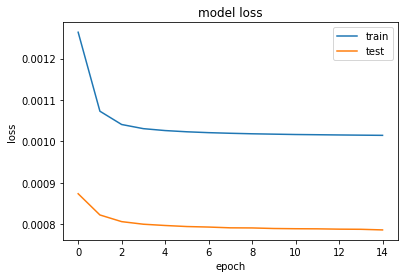

In [235]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

## Calcul du seuil d'anomalie avec le quantile à 0.999

In [236]:
predictions = autoencoder_dense.predict(X_train_)
mse_train = np.mean(np.power(X_train_ - predictions, 2), axis=1)
print('MSE:', np.quantile(mse_train, 0.999))

MSE: 0.0028515838374615133


In [239]:
predictions = autoencoder_dense.predict(X_test_)
mse_test = np.mean(np.power(X_test_ - predictions, 2), axis=1)
print('MSE:', np.quantile(mse_test, 0.999))

MSE: 0.002563760706253856


In [240]:
predictions = autoencoder_dense.predict(X_valid)
mse_valid = np.mean(np.power(X_valid - predictions, 2), axis=1)
print('MSE:', np.quantile(mse_valid, 0.999))

MSE: 0.002474413804830157


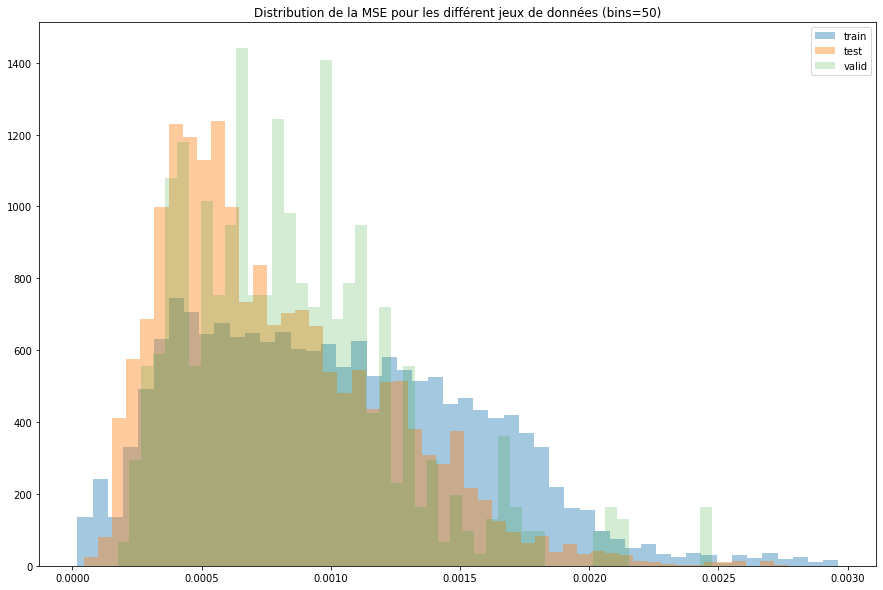

In [243]:
plt.figure(figsize=(15,10))
X = plt.hist(np.array(mse_train),bins=50, density=True,alpha= 0.4,label='train')
Y = plt.hist(np.array(mse_test),bins=50,density=True,alpha=0.4,label='test')
Z = plt.hist(np.array(mse_valid),bins=50,density=True,alpha=0.2,label='valid')
plt.title('Distribution de la MSE pour les différent jeux de données (bins=50)')
plt.legend()
plt.show()

In [251]:
An_score = len(mse_valid[mse_valid>float(np.quantile(mse_train, 0.99))])/len(pip)
print(An_score)

0.0


## commentaire : 
Notre premier encodeur ne fonctionne pas très bien, nous allons en construire un autre avec des réseaux récurents qui sont plus adapté pour les

## Construction d'un auto encodeur deuxième version basée sur les LSTM

In [253]:
X_train_ = np.reshape(X_train_, (X_train_.shape[0], 1, X_train_.shape[1]))
X_test_ = np.reshape(X_test_, (X_test_.shape[0], 1, X_test_.shape[1]))
X_valid_ = np.reshape(X_valid, (X_valid.shape[0], 1, X_valid.shape[1]))

In [178]:
X_train_ = np.reshape(X_train_, (X_train_.shape[0], X_train_.shape[2]))
X_test_ = np.reshape(X_test_, (X_test_.shape[0], X_test_.shape[2]))

In [184]:
X_train_.shape

(61693, 1000)

In [194]:
input_dim = X_train_.shape[2] # the # features
n = X_train_.shape[0]
#X_train_.shape[0]

nb_epoch = 15
batch_size = 32


input_layer = Input(shape=(1,input_dim))
encoder =LSTM(200, return_sequences=False, input_shape=(n,1,input_dim))(input_layer) 
x = RepeatVector(1)(encoder)
decoder  = LSTM(200, return_sequences=True)(x)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

history = autoencoder.fit(X_train_, X_train_,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_, X_test_),
                    verbose=1).history

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        (None, 1, 1000)           0         
_________________________________________________________________
lstm_91 (LSTM)               (None, 200)               960800    
_________________________________________________________________
repeat_vector_36 (RepeatVect (None, 1, 200)            0         
_________________________________________________________________
lstm_92 (LSTM)               (None, 1, 200)            320800    
_________________________________________________________________
dense_104 (Dense)            (None, 1, 1000)           201000    
Total params: 1,482,600
Trainable params: 1,482,600
Non-trainable params: 0
_________________________________________________________________
Train on 61693 samples, validate on 15261 samples
Epoch 1/15
61693/61693 [==============================] - 41s 65

In [287]:
#on met axis=2 car la dimentsion est (n,1,n_features=1000)
predictions = autoencoder.predict(X_train_)
mse_train = np.mean(np.power(X_train_ - predictions, 2), axis=2)
print('MSE:', np.quantile(mse_train, 0.999))

MSE: 0.0023858111400810807


In [289]:
predictions = autoencoder.predict(X_test_)
mse_test = np.mean(np.power(X_test_ - predictions, 2), axis=2)
print('MSE:', np.quantile(mse_test, 0.999))

MSE: 0.0020692500259516964


In [290]:
predictions = autoencoder.predict(X_valid_)
mse_valid = np.mean(np.power(X_valid_ - predictions, 2), axis=2)
print('MSE:', np.quantile(mse_valid, 0.999))

MSE: 0.0018918510804507111


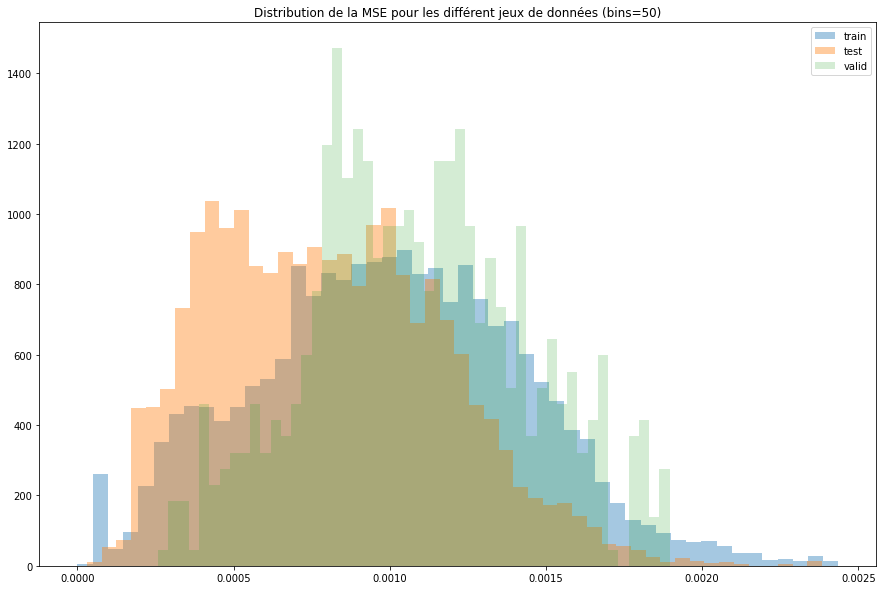

In [292]:
plt.figure(figsize=(15,10))
X = plt.hist(np.array(mse_train),bins=50, density=True,alpha= 0.4,label='train')
Y = plt.hist(np.array(mse_test),bins=50,density=True,alpha=0.4,label='test')
Z = plt.hist(np.array(mse_valid),bins=50,density=True,alpha=0.2,label='valid')
plt.title('Distribution de la MSE pour les différent jeux de données (bins=50)')
plt.legend()
plt.show()

In [271]:
.shape

(664,)

In [293]:
seuil =float(np.quantile(mse_train,0.99))
len(mse_valid[:,0][mse_valid[:,0]>=seuil])

0

## Commentaire 
Nous pouvons observer botre encodeurà base  RNN ne fonctionne pas beaucoup mieux et nous n'arrivons pas à détecter les prothèse PIP comme des anomalies.

Ou bien, les signalement ne sont pas assez diffférents ou bien, notre modèle ne capture pas les bonnes informations.

## Deuxième approche : 
- On entraine sur l'ensemble du dataset
- On labelise les prothèse PIP 1,0
- on entraine un autoencodeur
- on évalue le modèle avec un AUC

In [319]:
df['normal'] = df['DCO_ID'].apply(lambda x: 0 if x==2969 else 1)
X = df[['DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT']]

X_ = preprocess.fit_transform(X)

svd = TruncatedSVD(n_components=1000)
X_= svd.fit_transform(X_)

In [320]:
input_dim = X_.shape[1] # the # features
n =  X_.shape[0]

encoding_dim = 50 # first layer
hidden_dim = int(encoding_dim / 2) #hideen layer

nb_epoch = 2
batch_size = 32


input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)

decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder_dense = Model(inputs=input_layer, outputs=decoder)

autoencoder_dense.summary()

autoencoder_dense.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

history = autoencoder_dense.fit(X_, X_,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_, X_),
                    verbose=1).history

Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_181 (Dense)            (None, 50)                50050     
_________________________________________________________________
dense_182 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_183 (Dense)            (None, 50)                1300      
_________________________________________________________________
dense_184 (Dense)            (None, 1000)              51000     
Total params: 103,625
Trainable params: 103,625
Non-trainable params: 0
_________________________________________________________________
Train on 76954 samples, validate on 76954 samples
Epoch 1/2
76954/76954 [==============================] - 18s 229us/s

In [321]:
predictions = autoencoder_dense.predict(X_)
flat_output = np.reshape(predictions, (np.shape(X_)[0], -1))
flat_input = np.reshape(X_, (np.shape(X_)[0], -1))

cosine_similarity = np.sum(flat_output * flat_input, -1) / (np.linalg.norm(flat_output, axis=-1) + 0.000001) / (np.linalg.norm(flat_input, axis=-1) + 0.000001)
y = df['normal'].apply(lambda x: True if x == 0 else False)



auc = roc_auc_score(y, -cosine_similarity)
ap = average_precision_score(y, -cosine_similarity)

print("AUC : ",auc)
print('Average Precision score: ', ap)

AUC :  0.3590385628238475
Average Precision score:  0.006119098167439814


## Que se passes t-il si on change de classes ?

In [316]:
L  = df.groupby('DCO_ID').count().sort_values(by = 'DESCRIPTION_INCIDENT',ascending=False).iloc[5:15].index

In [318]:
df.groupby('DCO_ID').count().sort_values(by = 'DESCRIPTION_INCIDENT',ascending=False).iloc[:10]

,DESCRIPTION_INCIDENT,TYPE_VIGILANCE,LIBELLE_COMMERCIAL,DCO,REFERENCE_COMMERCIALE,ETAT_PATIENT,FABRICANT,CLASSIFICATION,normal
DCO_ID,,,,,,,,,
2577.0,18157,18157,18157,18157,18157,18157,18157,18157,18157
4001.0,2736,2736,2736,2736,2736,2736,2736,2736,2736
2975.0,2241,2241,2241,2241,2241,2241,2241,2241,2241
2542.0,2214,2214,2214,2214,2214,2214,2214,2214,2214
3011.0,1478,1478,1478,1478,1478,1478,1478,1478,1478
3016.0,1204,1204,1204,1204,1204,1204,1204,1204,1204
2965.0,1164,1164,1164,1164,1164,1164,1164,1164,1164
3262.0,1094,1094,1094,1094,1094,1094,1094,1094,1094
2696.0,1087,1087,1087,1087,1087,1087,1087,1087,1087


In [317]:
AUC = []
AP=[]
for l in L : 
    df['normal'] = df['DCO_ID'].apply(lambda x: 0 if x==l else 1)
    X = df[['DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT', 'normal']]
    
    X_ = preprocess.fit_transform(X)
    
    svd = TruncatedSVD(n_components=1000)
    X_= svd.fit_transform(X_)
    input_dim = X_.shape[1] # the # features
    n =  X_.shape[0]
    
    encoding_dim = 50 # first layer
    hidden_dim = int(encoding_dim / 2) #hideen layer
    
    nb_epoch = 2
    batch_size = 32
    
    
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation="tanh")(input_layer)
    encoder = Dense(hidden_dim, activation="relu")(encoder)
    
    decoder = Dense(encoding_dim, activation='relu')(encoder)
    decoder = Dense(input_dim, activation='tanh')(decoder)
    autoencoder_dense = Model(inputs=input_layer, outputs=decoder)
    
    autoencoder_dense.summary()
    
    autoencoder_dense.compile(optimizer='adam', 
                        loss='mean_squared_error', 
                        metrics=['accuracy'])
    
    history = autoencoder_dense.fit(X_, X_,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_, X_),
                    verbose=1).history
    predictions = autoencoder_dense.predict(X_)
    flat_output = np.reshape(predictions, (np.shape(X_)[0], -1))
    flat_input = np.reshape(X_, (np.shape(X_)[0], -1))
    
    cosine_similarity = np.sum(flat_output * flat_input, -1) / (np.linalg.norm(flat_output, axis=-1) + 0.000001) / (np.linalg.norm(flat_input, axis=-1) + 0.000001)
    y = X['normal'].apply(lambda x: True if x == 0 else False)
    
    
    
    auc = roc_auc_score(y, -cosine_similarity)
    ap = average_precision_score(y, -cosine_similarity)
    AUC.append(auc)
    AP.append(ap)
    print("AUC : ",auc)
    print('Average Precision score: ', ap)

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_141 (Dense)            (None, 50)                50050     
_________________________________________________________________
dense_142 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_143 (Dense)            (None, 50)                1300      
_________________________________________________________________
dense_144 (Dense)            (None, 1000)              51000     
Total params: 103,625
Trainable params: 103,625
Non-trainable params: 0
_________________________________________________________________
Train on 76954 samples, validate on 76954 samples
Epoch 1/2
76954/76954 [==============================] - 20s 257us/s

In [ ]:
## Commentaire

In [308]:
input_dim = X_.shape[1] # the # features
n =  X_.shape[0]

encoding_dim = 50 # first layer
hidden_dim = int(encoding_dim / 2) #hideen layer

nb_epoch = 2
batch_size = 32


input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)

decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder_dense = Model(inputs=input_layer, outputs=decoder)

autoencoder_dense.summary()

autoencoder_dense.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

history = autoencoder_dense.fit(X_, X_,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_, X_),
                    verbose=1).history

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 50)                50050     
_________________________________________________________________
dense_138 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_139 (Dense)            (None, 50)                1300      
_________________________________________________________________
dense_140 (Dense)            (None, 1000)              51000     
Total params: 103,625
Trainable params: 103,625
Non-trainable params: 0
_________________________________________________________________
Train on 76954 samples, validate on 76954 samples
Epoch 1/2
76954/76954 [==============================] - 18s 238us/s

In [309]:
predictions = autoencoder_dense.predict(X_)
flat_output = np.reshape(predictions, (np.shape(X_)[0], -1))
flat_input = np.reshape(X_, (np.shape(X_)[0], -1))

cosine_similarity = np.sum(flat_output * flat_input, -1) / (np.linalg.norm(flat_output, axis=-1) + 0.000001) / (np.linalg.norm(flat_input, axis=-1) + 0.000001)
y = X['normal'].apply(lambda x: True if x == 0 else False)



auc = roc_auc_score(y, -cosine_similarity)
ap = average_precision_score(y, -cosine_similarity)

print("AUC : ",auc)
print('Average Precision score: ', ap)

AUC :  0.678620366000437
Average Precision score:  0.29165587249958036
